In [1]:
# Run this before plotting
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Week 6 Lab: Don’t get lost in the crowd (scRNA-seq)

Skills: scRNA-seq, t-SNE, using Python analysis packags

## Intro

Before single-cell RNA-sequencing (scRNA-seq), bulk RNA-seq allowed the study of average expression level for each gene in a large population of cells. However, a limitation of bulk RNA-seq is that the method is insufficient for studying heterogenous systems such as early development or complex tissues like the brain. scRNA-seq measures the distribution of expression levels for each gene in a large population of cells which allows the study of cell-specific changes in the transcriptome.

In this lab, we will analyze scRNA-seq data of brain cells from a mouse brain sample with the goal of identifying expression signatures of different brain cell types. The sample was taken from a mouse embryo at 18 days of development. The brain region sampled consists of multiple cell types, including cortex, hippocampus, and the sub-ventricular zone. 1,303 cells were sequenced with approximately 71,000 reads per cell using 10X Genomics single-cell technology.

In this lab, we'll go through:
1. Exploring data formats for single cell data
2. Filtering poor-quality cells
3. Visualizing the distribution of expressed genes across cells
4. Identifying highly variable genes
5. Performing PCA and t-SNE 
7. Performing differential expression analysis 

<font color="red">**FOR YOUR REPORT (Intro-Q1)**</font> In your own words, summarize background and motivation for using scRNA-seq data. 

<font color="red">**FOR YOUR REPORT (Intro-Q2)**</font> In your own words, summarize your main results. You should probably wait until you've actually completed the analyses to write this part though!


### Summary of tools covered
In this lab we'll be using or referring to the following tools:

* [Cell Ranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger): the 10X Genomics tool for processing scRNA-seq fastq files. This pipeline performs many different analyses, including some quality control, alignment, and quantification of gene expression in each cell.
* [Scanpy](https://github.com/theislab/scanpy): a Python toolkit for scRNA-seq analysis.
 
### Summary of data provided
Data for this week can be found in `/datasets/cs185-sp21-A00-public/week6`. You should see the following folders, which were all created by Cell Ranger:

* `neuron_1k_v3_fastqs`: fastq files with raw reads
* `alignment`: BAM file with aligned reads
* `analysis`: analysis including dimensionality reduction, cell clustering, and differential expression
* `filtered_feature_bc_matrix`: filtered feature-barcode matrices containing only cellular barcodes
* `raw_feature_bc_matrix`: unfiltered feature-barcode matrices containing all barcodes

You will also see the folder `cellranger-3.0.2`, which contains the reference transcriptome for Cell Ranger if you choose to rerun the alignment + gene quantification yourself.

### Notes
This lab involves a lot of exploratory analysis of the single cell data, which will require you to set some thresholds on your own. Not everyone will end up getting the same results, which is ok! But please make sure you at least justify what you did and clearly describe any thresholds you used or decisions you made in the Methods section.

## 1. Exploring data formats

Before getting started, it is always a good idea to get some basic stats on the data you're dealing with.

Let's first look at the raw fastq data, which you can find in the `neuron_1k_v3_fastqs` directory. You will see two sets of fastq files: `neuron_1k_v3_S1_L001*.fastq.gz` and `neuron_1k_v3_S1_L002*.fastq.gz`. The `L001` and `L002` just refer to two lanes of the Illumina flowcell. For each lane of data, you will see:

* `neuron_1k_v3_S1_L00X_R1_001.fastq.gz` (contains the barcode and UMI for each read)
* `neuron_1k_v3_S1_L00X_R2_001.fastq.gz` (contains cDNA)
* `neuron_1k_v3_S1_L00X_I1_001.fastq.gz` (contains the sample index for each read)

(where `X` is either 1 or 2).

This is paired end data, and the `R1` and `R2` files denote the two reads in each pair, just like we're used to seeing for paired-end genome sequencing data. For each lane we also get an "index" fastq (the `I1` file), which lists a bunch of short sequences denoting the "index" for each read. Index sequences are special identifiers added to DNA samples during library preparation and this allows multiple libraries to be pooled and sequenced together. After sequencing, reads are demultiplexed from their corresponding index sequences so we know which reads came from which library. (We won't really need to worry about the indices here since we're treating everything as one sample.)

<font color="red">**FOR YOUR REPORT (Methods-Q1)**</font> Summarize the datasets we are starting with: what type of data are we analyzing? Where did they come from? How many reads are there in each dataset, and what is the read length? How many different libraries were pooled together (you can get this by counting the number of unique index reads, but ignoring index sequences with very few counts since those are likely just due to sequencing errors).

Now that we explored the raw data, the next step is to align the reads to a reference transcriptome, similar to what we did in Lab 4 on bulk RNA-sequencing. 

For this, we will introduce a tool, Cell Ranger from 10X Genomics, which can perform a wide variety of useful scRNA-seq analyses. For our analyses we'll be using the `cellranger count` pipeline. This pipeline takes in fastq files in the format we have above, and:

1. Aligns reads to a reference transcriptome
2. Performs basic QC including filtering and barcode/UMI counting
3. Generates feature-barcode matrices
4. Performs clustering
5. Performs gene expression analysis

This tool can take several hours to run on the example dataset, so we have run this part for you using the command:

```shell
cellranger count \
   --id=mouse_brain \
   --fastqs=/datasets/cs185s-sp19-public/week6/neuron_1k_v3_fastqs \
   --sample=neuron_1k_v3 \
   --transcriptome=cellranger-3.0.2/refdata-cellranger-mm10-3.0.0
```
**Note: this may take around 3 hrs or more to run, which is why we have run it for you. Just use the output as is.**

Cellranger performs alignment to the reference transcriptome (in this case, we used the mm10 reference genome) and outputs BAM files. You can use samtools to take a look at the alignment files. 

After alignment, Cell Ranger quantifies the number of reads coming from each gene in each cell. This is represented as a matrix, with each row (feature) corresponding to a gene and each column corresponding to a cell. Recall that individual cells are identified using barcodes. Cell Ranger names the output of these counts "feature-barcode" matrices.

You will see two folders containing these matrices:
* `raw_feature_bc_matrix`: contains data for all barcodes detected
* `filtered_feature_bc_matrix`: contains data that has been filtered to remove barcodes corresponding to empty droplets that did not contain any cells (this occasionally happens). 

Including empty droplets would just make our matrix even more sparser than it already is, so we will focus only on the filtered data. Read more about how single cells are sequenced using GEM [here](https://community.10xgenomics.com/t5/10x-Blog/Single-Cell-RNA-Seq-An-Introductory-Overview-and-Tools-for/ba-p/547)

In the filtered matrix directory you will find three files: 
* `matrix.mtx.gz`: the matrix represented in Matrix Market format, which is used to store sparse matrices (meaning most of the elements are zero)
* `features.tsv.gz`: a list containing the gene name for each row of the matrix
* `barcodes.tsv.gz`: a list containing the barcode for each column of the matrix

Scroll through these files to make sure you understand the format.

<font color="red">**FOR YOUR REPORT (Methods-Q2)**</font> Summarize the methods used to perform alignment and gene expression quantification. What cell ranger command was used? Which reference transcriptome? What were the inputs and outputs? Specify any non-default options. 

After exploring the data formats, we're going to load the matrix to work with. For this task, we're going to use the python library Scanpy, a toolkit for scRNA-seq analysis.

First, you'll need to install this library and some dependencies. You can install these locally by doing:

```shell
pip install --upgrade --user pip # upgrade pip

# Install scanpy and its dependencies
pip install --user 'scanpy[leiden]'
pip install --user --upgrade scikit-learn numba
pip install --user --upgrade louvain

```

To test that the install finished successfully, try loading the library (as in the code below). Ask a friend or TA if this isn't working, since you will need to this for the rest of the lab.

```python
import scanpy as sc
```

Scanpy stores the data in an AnnData object. Explore what an [AnnData]( https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData) object is and the different methods available. The code below shows how to import scanpy, print out what versions of libraries it is using, and load 10X data output from Cell Ranger into an AnnData object.

In [19]:
import scanpy as sc
print(sc.__version__)
sc.settings.verbosity = 3
# Load in the data
adata = sc.read_10x_mtx("/datasets/cs185-sp21-A00-public/week6/filtered_feature_bc_matrix/",var_names='gene_symbols', cache=True)
adata

... reading from cache file cache/datasets-cs185-sp21-A00-public-week6-filtered_feature_bc_matrix-matrix.h5ad


1.7.2


AnnData object with n_obs × n_vars = 1301 × 31053
    var: 'gene_ids', 'feature_types'

Note 1: Unlike previous weeks, where most of our analyses involved the command line, this week we will mostly be analyzing our data using Python. This is for several reasons: first, currently the most robust tools for scRNA-seq analysis are available only in Python (or R) libraries! And second, sometimes in the real world you'll be faced with a research task, and it might be that the only tool available for what you need requires you to write code in a specific language that you may or may not be comforable with (e.g., differential expression analysis tools typically require R). You don't need to be an expert in that language, but will need to figure out enough to wrangle the tool into doing what you want.

Note 2: you may find it helpful to explore using the library in a separate notebook file (which you will not turn in) rather than experimenting here inside the instructions notebook. But if you prefer you can also play around within this notebook.

<font color="red">**FOR YOUR REPORT (Methods-Q3)**</font> Cite the library and version you used to load in the feature barcode matrix.  How many genes and total cells were included in the loaded data?

## 2. Preprocessing the data

Before we start the analysis, we need to preprocess the data and filter out the poor quality parts of the matrix. We will perform two levels of filtering:

* Filtering *cells*: We will want to filter cells (columns) that don't look very reliable. One sign a cell didn't get sequenced very well is if not that many genes are expressed (lots of non-zero counts).
* Filtering *genes*: We will want to filter genes (rows) that are not expressed in at least some of our cells since those won't be very interesting. We will also filter genes that are not expressed highly enough for us to get good data.

Filter out the cells that have less than 100 genes expressed, genes that are detected in less than 5 cells, and genes that have a total count of less than 15. Use the Scanpy library to do so. You may find the functions `sc.pp.filter_cells` and `sc.pp.filter_genes` useful (see https://icb-scanpy.readthedocs-hosted.com/en/stable/api/ for options available and more on how to use these). For example:

```python
sc.pp.filter_cells(adata, ....)
```
will perform the specified filtering and update the AnnData object `adata` in place.


<font color="red">**FOR YOUR REPORT (Results-Q1)**</font> Report the number of cells and number of genes you filtered out at each step (i.e. after each cell-level and gene-level filter). 

Let's next look at the most highly expressed genes in the dataset using Scanpy. Use `sc.pl.highest_expr_genes(adata, n_top=20)` to plot the top 20 highest expressed genes. This command will show the genes along the y axis and the distribution of their counts per cell along the x-axis.

<font color="red">**FOR YOUR REPORT (Results-Q2)**</font> What are the top 6 highest expressed genes? What do you notice in common with them? (you do not need to include the plot in your report).

In [21]:
sc.pp.filter_cells(adata, min_genes=101) #28 filtered
sc.pp.filter_genes(adata, min_cells=5) #16383 filtered
sc.pp.filter_genes(adata, min_counts=15) #13125 filtered

filtered out 28 cells that have less than 101 genes expressed
filtered out 16383 genes that are detected in less than 5 cells
filtered out 1545 genes that are detected in less than 15 counts


normalizing counts per cell
    finished (0:00:00)


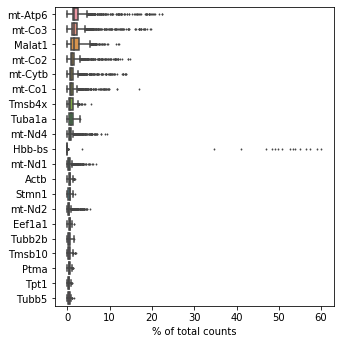

In [22]:
sc.pl.highest_expr_genes(adata, n_top=20)

You probably noticed that the highest expressed genes started with "mt." This stands for mitochondrial.

So what are mitochondrial genes? These are genes expressed from mitchondria, which are circular pieces of DNA present in cells at high copy number. High numbers of mitochondrial transcripts are indicators of poor sample quality.
This could mean the cell is undergoing apoptosis (dying) or for some reason has higher than normal metabolic activity. For our analysis, this is not the case and we wouldn't want to cluster our cells based off of cells' stress levels. We will explore this in the next section where we use violin plots to visualize the distribution of mitochondrial genes.

## 3. Visualizing distribution of genes in cells

A nice way of visualizing the distribution of some data is through violin plots. Violin plots are like box plots in the sense that they show medians, ranges and variabilities. However, box plots do not show the full distribution of the data. Violin plots show the probability density of the data at different values. The shape of the violin plot is just the distribution of the data plotted sideways on both sides of a box plot. Look [here](https://blog.bioturing.com/2018/05/16/5-reasons-you-should-use-a-violin-graph/) for a visualization of how violin plots can capture information about the data distribution that wouldn't be captured in a box plot.

To decide what further filtering we would need to do, let's look at the violin plots of the distribution of:
1. The number of genes expressed per cell.
2. The percentage of genes for each cell that are mitochondrial.
3. Total counts across cells. (here counts is the number of reads that have been mapped back to the transcriptome for each cell).

Before we plot these we need to compute them for each cell. AnnData objects contain an `obs` variable (e.g. `adata.obs`) which is just a data frame (like we've seen in `pandas`) with different information about each cell. For instance, `adata.obs["n_genes"]` gives the number of genes found per cell. Type `adata.obs` to see the columns available.

The code below adds observations `n_counts` and `percent_mito` to `adata.obs`. Even though this is given to you, you need to work through what it is doing so you can describe it in your report.

```python
import numpy as np
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
## add the total counts per cell as observations-annotation to adata
sc.pp.filter_cells(adata, min_genes=0)
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

# You can sort by a column using e.g. adata.obs.sort_values(colname, ascending=False) to get highest values at the top
```

<font color="red">**FOR YOUR REPORT (Methods-Q4)**</font> Describe how the percentage of mitochondrial genes and number of counts are calculated from the matrix to add to the observations for the AnnData object. What were the top 3 barcodes of the cells that had the highest percentage of mitochondrial genes? What were the top 3 barcodes of the cells that had the highest number of counts?

<font color="red">**FOR YOUR REPORT (Results-Q3)**</font> Make violin plots using Scanpy to visulize the distribution of `n_genes`, `percent_mito`, and `n_counts` across all cells. Describe the distributions of each value and include an image of the plots.

You may find the function `sc.pl.violin` helpful (described [here](https://scanpy.readthedocs.io/en/latest/api/scanpy.pl.violin.html#scanpy.pl.violin)). Try using different options to make your plot look nice!

<font color="red">**FOR YOUR REPORT (Results-Q4)**</font> Make scatter plots of all pairs of these variables (`n_counts` vs. `percent_mito`, `n_counts` vs. `n_genes`, and `n_genes` vs. `percent_mito`). You can use either Scanpy or matplotlib to do this. Include the scatter plots in your report. Describe and interpret the shape of these plots. For instance: are the cells with the most mitochondrial genes the same cells with many counts? Are there any outlier points? What could those mean?

We should remove cells that have too many mitochondrial genes expressed or too high total counts. Too many mitochondrial genes can indicate apotosis of the cell. Too many total counts can indicate some technical problem like two cells in one GEM. Determine good numbers to use for filtering mitochondrial genes and too many total counts based on looking at the plots you made in Results-Q4. Then use those thresholds to filter your data. If you think it is appropriate, you may also decide on other values. Just be sure to justify your decisions in your report and provide a description of what you did.

The following gives an idea of how to filter based on columns in `adata.obs`:

```python
adata_filt = adata[(adata.obs[col1]<threshold1) & (adata.obs[col2]<threshold2), :] #keep cells matching these criteria. keep all genes (":" means all)
```

<font color="red">**FOR YOUR REPORT (Methods-Q5)**</font> Describe how you filtered cells with too high a percentage of mitochondrial genes and too high total counts. What cutoffs did you choose and why? If you used any other filters describe those here.

<font color="red">**FOR YOUR REPORT (Results-Q5)**</font> Make violin plots of the distributions of each variable (`n_genes`, `percent_mito`, and `n_counts`) now after filtering. Make scatter plots again of what you did for <font color="red">**Results-Q4**</font> after filtering. How do the plots look? How many cells are you left with after filtering?

<font color="red">**FOR YOUR REPORT (Results-Q6)**</font> Check the highest expressed genes of the cells after filtering. What are the top 6 highest expressed genes? How do they compare to those found before filtering? Pay attention to both the set of genes at the top, but also the values on the x-axis that indicate the percent of total counts. (Don't worry if you still see *some* mitochondrial genes in this list.)

You might still see some outlier cells with a tiny number of genes expressed, and one top expressed gene (Hbb-bs) that accounts for a huge percentage of the total counts. What do you think is causing those two artifacts?

## 4. Identifying highly variable genes

Since our goal is to use scRNA-seq to identify different cell sub-types, we are most interested in genes that are differentially expressed across different cells. So we will want to restrict analysis to highly variable genes.

First, we'll need to do some normalization so we can compare expression across cells. Before normalization, the total reads derived from each cell may differ substantially. We will want to transform the data by dividing each column (cell) of the expression matrix by a “normalization factor,” an estimate of the library size relative to the other cells. It is also standard practice to log transform our data to decrease the variability of our data and transform skewed data to approximately conform to normality.

Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells. Then logarithmize the data. The code below shows how to do this.

```python
sc.pp.normalize_per_cell(adata_filt, counts_per_cell_after=1e4) # normalize to 10,000 reads/cell
sc.pp.log1p(adata_filt) # log transform
```

We use **dispersion** to quantify the variability of each gene. Dispersion is a measure of how "stretched" or "squeezed" a distribution is and is typically computed as "variance/mean" (other metrics are sometimes used). Higher dispersion means higher variability. In Scanpy, genes are first binned based on mean expression levels. Normalized dispersion for each gene is then computed as the absolute difference between the gene's dispersion and the median dispersion of genes in that bin, divided by the median deviation within each bin. This means that for each bin of mean expression, highly variable genes are selected.

The Scanpy function `highly_variable_genes` (see [here](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.pp.highly_variable_genes.html)) is useful for finding genes with highest dispersion. e.g.:

```python
sc.pp.highly_variable_genes(adata_filt, min_mean=XXXX, max_mean=XXX, min_disp=XXX) # replace XXX
```

<font color="red">**FOR YOUR REPORT (Methods-Q6)**</font> Describe methods and filters you used to find highly variable genes.

Note, in addition to `obs`, which contains data *per cell*, the AnnData object has `var`, which has data *per gene*, also in a pandas dataframe. The function above will add several variables to this data frame including:
* `highly_variable`, which is a boolean vector with one entry per gene. It is set to True for the highly variable genes based on the values we used in the function above.
* `dispersions_norm`: normalized dispersion for each gene.

Type `adata_filt.var` to see the data frame. You can create a new AnnData object with only the highly variable genes using the syntax:

```python
adata_var = adata_filt[:, adata_filt.var["highly_variable"]] 
```

<font color="red">**FOR YOUR REPORT (Results-Q7)**</font> How many genes are in your highly variable set? What are the top 5 most variable genes? Why do we only care about the genes that differ between the cells?

## 5. Performing PCA and t-SNE

We will perform two clustering methods, PCA and TSNE (t-distributed Stochastic Neighbor Embedding) analysis on our dataset. Both methods are ways to look at variation in our data, however, PCA is more suitable for bulk RNA-seq data while t-SNE is used more for scRNA-seq data since it is better at dealing with sparse matrices. Refer to lab 3 for details on PCA and refer to Wednesday lecture slides for details on t-SNE.

First, we will look at the outputs of these methods as computed by Cell Ranger. Then we'll try implementing t-SNE ourselves using Scanpy.

One of the outputs of Cell ranger is the results of performing PCA on the filtered feature-barcode matrix. This projection is stored in `week6/analysis/pca/10_components/projection.csv` in the `/datasets` public directory. Using this file, plot the data projected along the first two principle components.

Another output file of Cellranger is the dimensionality reduction with t-SNE. With `week6/analysis/tsne/2_components/projection.csv`, plot the two components. Clusters are found with the graph-based clustering approach. For both PCA and TSNE plots, color the clusters with `week6/analysis/clustering/graphclust/clusters.csv`. These are cluster labels that CellRanger learned based on k-means clustering of the cells.

Note, you can load these files in `pandas` using:

```python
pca = pd.read_csv("/datasets/cs185-sp21-A00-public/week6/analysis/pca/10_components/projection.csv")
tsne = pd.read_csv("/datasets/cs185-sp21-A00-public/week6/analysis/tsne/2_components/projection.csv")
clusters = pd.read_csv("/datasets/cs185-sp21-A00-public/week6/analysis/clustering/graphclust/clusters.csv")           
```

<font color="red">**FOR YOUR REPORT (Results-Q8)**</font> Include your PCA and t-SNE plots based on CellRanger output. Describe how the plots are similar or different. How do the cells cluster? How many clusters do you see?

Now let's try to run t-SNE ourselves using Scanpy. The following functions will be useful:

* `sc.tl.tsne` (see [here](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.tl.tsne.html)). You'll want to run this only on `adata_var`, or whatever you named your new AnnData object containing only the most variable genes. This will compute the t-SNE projection for each cell in an 2d numpy array in `adata_var.obsm["X_tsne"]`. If you just type `adata_var` you should see this.
* `sc.pp.neighbors` computes neighborhood graphs. Needed to run Louvain clustering.
* `sc.tl.louvain` clusters cells based on expression profiles. This is needed to color cells by cluster.


Look at the Scanpy documentation to see how to create a t-SNE plot on our filtered dataset. Your code may look something like:

```python
sc.tl.tsne(data, n_pcs = 7)
sc.pp.neighbors(data, n_neighbors=10)
sc.tl.louvain(data)
sc.pl.tsne(data, color=['louvain'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)
```

<font color="red">**FOR YOUR REPORT (Methods-Q7)**</font> Describe the methods you used to run t-SNE using Scanpy.

<font color="red">**FOR YOUR REPORT (Results-Q9)**</font> Include your t-SNE image based on Scanpy. How do the cells cluster? How many clusters do you see? Is your plot similar or different than the one output by Cell Ranger?

Also try to color your tsne plot based on the clusters identified by Cell Ranger (from the clustesr.csv file). Do cells from the same clusters from 10X cluster together on your t-sne plot?

## 6. Looking at differential expression

After distinguishing clusters or cell groups, we want to look at which genes help define each of the clusters. After running t-SNE, you can use:

```python
sc.tl.rank_genes_groups(data, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(data, n_genes=10, sharey=False)
```

For comparison, Cellranger also outputs a table showing which features are differentially expressed in each cluster relative to all other clusters. Load the table, `week6/analysis/diffexp/graphclust/differential_expression.csv` in pandas and look at the differentially expressed genes in each cluster. Does it look like any of your clusters are similar to those found by Cellranger?

<font color="red">**FOR YOUR REPORT (Results-Q10)**</font> What are the top 3 genes for each cluster reported by Scanpy? Do the genes you find differ for each cluster? What might be a possible explanation for the differences in the variable genes found in each cluster? Tip: Think of the different types of cells and their function in the brain. 

<font color="red">**FOR YOUR REPORT (Results-Q11)**</font> What are the top 3 genes for each cluster reported by Cellranger? Are they the same ones as the ones you found using Scanpy? If they differ, provide a possible explanation why this might be the case.

## Discussion

**<font color="red">FOR YOUR REPORT: See questions Q1-Q3 in the report</font>** Specific prompts are given in the report notebook.

## References

Data used for the lab is publicly available from 10x genomics: https://www.10xgenomics.com/solutions/single-cell/

<font color="red">**FOR YOUR REPORT (References-Q1)**</font> Provide at least 2 works that you cite in your report. For example, you will likely reference Cellranger, Scanpy, and 10x genomics where the data is taken from.